In [1]:
using Gadfly, DataFrames

INFO: Recompiling stale cache file /home/cfusting/.julia/lib/v0.4/DataArrays.ji for module DataArrays.
INFO: Recompiling stale cache file /home/cfusting/.julia/lib/v0.4/Gadfly.ji for module Gadfly.
INFO: Recompiling stale cache file /home/cfusting/.julia/lib/v0.4/DataFrames.ji for module DataFrames.
INFO: Recompiling stale cache file /home/cfusting/.julia/lib/v0.4/Distributions.ji for module Distributions.
INFO: Recompiling stale cache file /home/cfusting/.julia/lib/v0.4/KernelDensity.ji for module KernelDensity.


In [2]:
function imitate(nodes::Int, prob::Float64, moved::Int)
    tot = 0
    for i in 1:(nodes - moved)
        for j in 1:moved
            if prob > rand() 
                tot = tot + 1 
                break
            end 
        end
    end
    tot
end

imitate (generic function with 1 method)

Suppose we have $n$ nodes and $m$ moved. We wish to determine how many nodes will imitate at least one of the $m$ nodes and move themselves. Each node will imitate with probability $p$. The number of nodes available to imitate is $k = n - m$. We can think of each of these $k$ nodes as having $m$ chances to imitate a node that moved:

\begin{equation*}
  X \sim\binom{m}{x}p^x(1-p)^{m-x}
\end{equation*}

A node moves if it imitated at least one of the other nodes:

\begin{equation*}
  P(X \geq 1) = 1 - P(X < 1) = 1 - (1-p)^m = z
\end{equation*}

where $z$ is the probability a node moves. The distribution representing the probability that $v$ nodes move is given by:

\begin{equation*}
    V \sim \binom{k}{v}z^v(1-z)^{k-v}
\end{equation*}

Thus we can determine the expected number of nodes that will move:

\begin{equation}
  \langle V \rangle = k - k(1 - p)^m
  \label{eq:expv}
\end{equation}


In [3]:
function expectedMoves(n::Int, p::Float64, m::Int)
    k = n - m
    k - k * (1 - p)^m
end

expectedMoves (generic function with 1 method)

In [4]:
function expectedMovesSim(n::Int, p::Float64, m::Int, trials::Int)
    im = 0
    for i in 1:trials
        im = im + imitate(n, p, m)
    end
    im / trials
end

expectedMovesSim (generic function with 1 method)

In [5]:
n = 10
p = .5
m = 5
expectedMoves(n, p, m)

4.84375

In [6]:
expectedMovesSim(n, p, m, 10^6)

4.843395

In [7]:
function catalyze(nodes::Int, prob::Float64, moved::Int, limit::Int = 10^4; force = true)
    record = [1]
    itr = 1
    while moved > 0 && itr < limit
        moved = imitate(nodes, prob, moved)
        push!(record, moved)
        if force && moved == 0
            moved = 1
        end
        itr = itr + 1
    end
    record
end

catalyze (generic function with 2 methods)

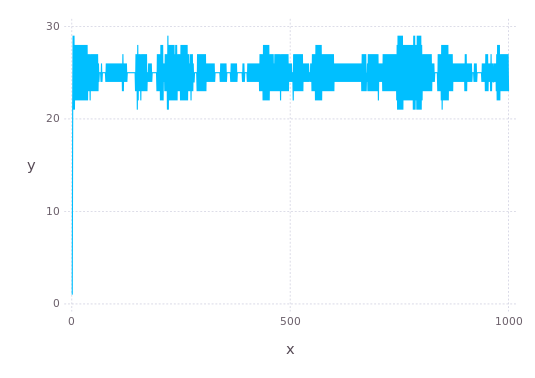

In [8]:
record = catalyze(50, .2, 3, 10^3, force = false);
mean(record);
plot(x = [x for x = 1:length(record)], y = record, Geom.line)

In [9]:
function simulate(folds::Int, totalnodes::Int, numprobs::Int, probstop::Float64)
    analysisnodes::Int = totalnodes - 1
    allmoves = Array{Float64}(analysisnodes, numprobs)
    alltime = Array{Float64}(analysisnodes, numprobs)
    probs = linspace(.01, probstop, numprobs)
    a = 1
    for p in probs, i in 2:totalnodes
        avgmoves = 0
        avgtime = 0
        for j in 1:folds
            record = catalyze(i, p, 1)
            avgmoves = avgmoves + (mean(record))
            avgtime = avgtime + length(record)
        end
        allmoves[a] = avgmoves / folds
        alltime[a] = avgtime / folds
        #print("|$i, $p: $(allmoves[a])")
        a = a + 1
    end
    (allmoves, alltime)
end

simulate (generic function with 1 method)

In [10]:
folds = 10
nodes = 30 
probs = 10
probstop = .99
probvalues = linspace(.01, probstop, probs)
(moves, time) = simulate(folds, nodes, probs, probstop);

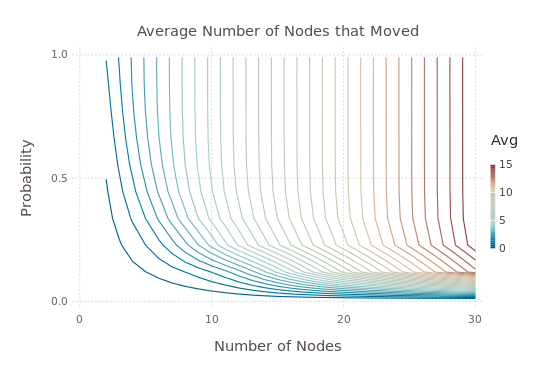

In [11]:
plot(z = moves, x = [x for x = 2:nodes], y = [x for x in probvalues],
Geom.contour(levels=30), Guide.xlabel("Number of Nodes"), Guide.ylabel("Probability"),
Guide.title("Average Number of Nodes that Moved"), Guide.colorkey("Avg"))

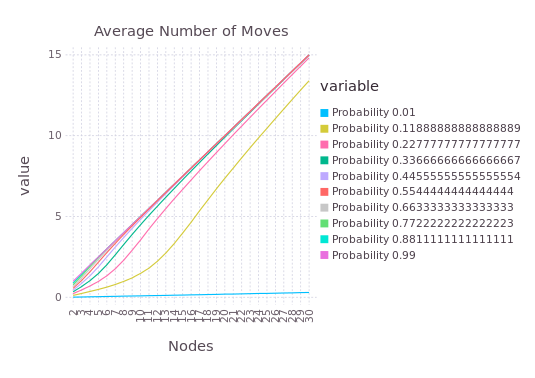

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:38
 in anonymous at no file
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/cfusting/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/cfusting/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[12], in expression starting on line 2


In [12]:
data = DataFrame([2:nodes moves])
names!(data, convert(Array{Symbol, 1}, ["Nodes", [symbol("Probability $x") for x in probvalues]]))
dat = stack(data, [2:probs + 1]);
plot(dat, x = "Nodes", y = "value", color = "variable", Geom.line,
Guide.title("Average Number of Moves"), Stat.xticks(ticks = [x for x = 2:nodes]))

Consider a network with weights $w \in A = [0,1)$ representing the probability of imitation.

In [3]:
using LightGraphs, TikzGraphs, StatsBase

In [4]:
"""
With probabilty of connection `p` generate a random symmetric adjacency matrix of uniformly 
distributed weights between 0 and 1.
"""
function randomweights(n, p, divider) 
    W = zeros(n, n)
    for i in 1:n
        W[i,i] = 0
        for j in i+1:n
            if p > rand()
                r = rand() / divider
                W[i,j] = r
                W[j,i] = r
            end
        end
    end
    W
end

randomweights (generic function with 1 method)

In [5]:
"""
With probabilty of connection `p` create a symmetric adjacency matrix of weights of weight 
`w`.
"""
function staticweights(n, p, w)
    W = zeros(n, n)
    for i in 1:n, j in i+1:n
        if p > rand()
            W[i,j] = w
            W[j,i] = w
        end
    end
    W
end

staticweights (generic function with 1 method)

In [6]:
"""
Changes the probabalistic weight of the edge between two nodes.
"""
function tenth(W, i, j; strengthen = true)
    if strengthen
        p = W[i,j] + 1/10 * (1 - W[i,j])
    else
        p = W[i,j] - 1/10 * W[i,j]
    end
    #print("New distance $dist\n")
    W[i,j] = p
    W[j,i] = p
end

tenth (generic function with 1 method)

In [7]:
"""
Given a symmetric weight matrix `W`, an ordered set of nodes that moved in the previous 
timestep, and a metric defining how to adjust the weights (when `dynamic = true`) evaluate
and return an ordered set of nodes that moved and adjust the weights of `W` accordingly.
"""
function imitate(W, moved, metric; dynamic = true)
    #print("Nodes moved $moved\n")
    n = size(W, 1)
    nodes = setdiff(IntSet(1:n), moved)
    imitated = IntSet()
    for i in nodes, j in moved
        if W[i,j] > rand()
            #print("$i imitated $j\n")
            push!(imitated, i)
            if dynamic metric(W, i, j) end 
        else
            if dynamic metric(W, i, j; strengthen = false) end
        end
    end
    imitated
end

imitate (generic function with 1 method)

In [8]:
n = 6
p = 1/2
divider = 2
W = randomweights(n, p, divider)
W

6x6 Array{Float64,2}:
 0.0        0.0523347  0.0       0.42303   0.0890207  0.0      
 0.0523347  0.0        0.0       0.0       0.0        0.0      
 0.0        0.0        0.0       0.189449  0.477579   0.47255  
 0.42303    0.0        0.189449  0.0       0.0        0.45196  
 0.0890207  0.0        0.477579  0.0       0.0        0.0502325
 0.0        0.0        0.47255   0.45196   0.0502325  0.0      

In [9]:
nodes = IntSet(sample(collect(1:n), 2, replace = false))

IntSet([1, 2])

In [10]:
ctr = 1
while length(nodes) > 0 && ctr < 100
    nodes = imitate(W, nodes, tenth)
    ctr = ctr + 1
    #print("nodes : $(length(nodes)), ctr : $ctr \n")
end
triu(W)
W

6x6 Array{Float64,2}:
 0.0        0.0523347  0.0       0.380727  0.0801186  0.0      
 0.0523347  0.0        0.0       0.0       0.0        0.0      
 0.0        0.0        0.0       0.189449  0.477579   0.47255  
 0.380727   0.0        0.189449  0.0       0.0        0.45196  
 0.0801186  0.0        0.477579  0.0       0.0        0.0502325
 0.0        0.0        0.47255   0.45196   0.0502325  0.0      

In [11]:
ctr - 1

1

Things to look at:

* Components $c_i$ 
* nodes $n$
* number of nodes in $c_i \equiv n_{c_i}$
* degree $k$ 
* weights $W$
* distance $D=1-W$


1. How long does an idea bounce around $c_i$ given $k_{avg}$ and $d_{avg}$ (static and dynamic cases)?
2. How does $d_{avg}$ behave as a function of $n_{c_i}$ and $W$

In [12]:
"""
Create an undirected graph without self loops from a weigth matrix.
"""
function graphfromweights(W)
    n = size(W, 1)
    g = Graph(n)
    for i in 1:n, j in i+1:n
        if W[i,j] > 0 
            add_edge!(g, i, j)
        end
    end
    g
end

graphfromweights (generic function with 1 method)

In [13]:
n = 6
p = 1/3
w = 1/2
W = staticweights(n, p, w)

6x6 Array{Float64,2}:
 0.0  0.0  0.5  0.0  0.5  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.5  0.0  0.0  0.0  0.5  0.5
 0.0  0.0  0.0  0.0  0.5  0.0
 0.5  0.0  0.5  0.5  0.0  0.5
 0.0  0.0  0.5  0.0  0.5  0.0

In [14]:
g = graphfromweights(W)

{6, 6} undirected graph

In [15]:
degree(g)

6-element Array{Int64,1}:
 2
 0
 3
 1
 4
 2

In [16]:
1 - W

6x6 Array{Float64,2}:
 1.0  1.0  0.5  1.0  0.5  1.0
 1.0  1.0  1.0  1.0  1.0  1.0
 0.5  1.0  1.0  1.0  0.5  0.5
 1.0  1.0  1.0  1.0  0.5  1.0
 0.5  1.0  0.5  0.5  1.0  0.5
 1.0  1.0  0.5  1.0  0.5  1.0

In [32]:
function visit(node, D, vis, counted, last = 0)
    #print("Visiting node $(node)!\n")
    dist = 0
    for i in 1:size(D, 2)
        if i != last && D[i, node] < 1 
            if !((i, node) in counted)
                push!(counted, (i, node))
                push!(counted, (node, i))
                dist = dist + D[i, node]
            end
            if !(i in vis)
                push!(vis, i)
                dist = dist + visit(i, D, vis, counted, node)
            end
        end
    end 
    dist
end

visit (generic function with 2 methods)

In [33]:
"""
Calculate the total distance between nodes connected to `node` in `W`.
"""
function distance(W, node)
    vis = IntSet()
    counted = Set()
    D = 1 - W
    n = size(D, 2)
    push!(vis, node)
    visit(node, D, vis, counted)
end

distance (generic function with 1 method)

In [19]:
connected_components(g)

2-element Array{Array{Int64,1},1}:
 [1,3,4,5,6]
 [2]        

In [20]:
distance(W, 1)

Visiting node 1!
Visiting node 3!


3.0

In [21]:
type Component
    nodes::Array{Int}
    distance::Float64
    size::Int
    
    Component(nodes, distance) = new(nodes, distance, length(nodes))
end

In [35]:
function calccompdist(g, W)
    coms = connected_components(g) 
    res = Component[]
    for i in coms
        if length(i) > 1
            push!(res, Component(i, distance(W, i[1])))
        end
    end
    res
end

calccompdist (generic function with 1 method)

In [36]:
calccompdist(g, W)

1-element Array{Component,1}:
 Component([1,3,4,5,6],3.0,5)